In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import colorsys
import random

In [2]:
def erosion(image,diameter):
    img=np.pad(image,((diameter//2,diameter//2),(diameter//2,diameter//2)),'constant')
    out=np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j]=np.min(img[i:i+diameter,j:j+diameter])
    return out

def dialation(image,diameter):
    img=np.pad(image,((diameter//2,diameter//2),(diameter//2,diameter//2)),'constant')
    out=np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i,j]=np.max(img[i:i+diameter,j:j+diameter])
    return out

In [3]:
def TPA(image):
    cluster=np.zeros(image.shape,dtype=np.int64)
    count=0
 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i==0:
                if j==0 and image[i,j]==1:
                    count=count+1
                    cluster[i,j]=count   
                else:
                    if image[i,j]==1 and image[i,j-1]==1:
                        cluster[i,j]=cluster[i,j-1]
                    elif image[i,j]==1:
                        count=count+1
                        cluster[i,j]=count
            else:
                if j==0 and image[i,j]==1 and image[i-1,j]==1 and image[i-1,j+1]==1:
                    cluster[i,j]=min(cluster[i-1,j],cluster[i-1,j+1])
                elif j==0 and image[i,j]==1 and image[i-1,j]==0 and image[i-1,j+1]==1 :
                    cluster[i,j]=cluster[i-1,j+1]
                
                elif j==0 and image[i,j]==1 and image[i-1,j]==1 and image[i-1,j+1]==0 :
                    cluster[i,j]=cluster[i-1,j]
                
                elif j==0 and image[i,j]==1 and image[i-1,j]==0 and image[i-1,j+1]==0 :
                    count+=1
                    cluster[i,j]=count
                elif j>0 and image[i,j]==1:
                    temp=[]
                    if image[i-1,j]==1:
                        temp.append(cluster[i-1,j])
                    if image[i-1,j-1]==1:
                        temp.append(cluster[i-1,j-1])
                    if j<int(image.shape[1])-1:
                        if image[i-1,j+1]==1:
                            temp.append(cluster[i-1,j+1])
                    if image[i,j-1]==1:
                        temp.append(cluster[i,j-1])
                    if len(temp)>0:
                        cluster[i,j]=min(temp)
                    else:
                        count+=1
                        cluster[i,j]=count
                    
                
    
    mapping=np.arange(count+1)
    
    for i in range(0,image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]==1:
                if j==0:
                    if cluster[i-1,j]!=cluster[i,j] and image[i-1,j]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j])]=min(cluster[i,j],cluster[i-1,j])
                    if cluster[i-1,j+1]!=cluster[i,j] and image[i-1,j+1]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j+1])]=min(cluster[i,j],cluster[i-1,j+1])
                    
                else:
                    if cluster[i-1,j]!=cluster[i,j] and image[i-1,j]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j])]=min(cluster[i,j],cluster[i-1,j])
                    if cluster[i,j]!=cluster[i,j-1] and image[i,j-1]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i,j-1])]=min(cluster[i,j],cluster[i,j-1])
                    if j<image.shape[1]-1:
                        if cluster[i-1,j+1]!=cluster[i,j] and image[i-1,j+1]==1 and image[i,j]==1:
                            mapping[max(cluster[i,j],cluster[i-1,j+1])]=min(cluster[i,j],cluster[i-1,j+1])
                    if cluster[i-1,j-1]!=cluster[i,j] and image[i-1,j-1]==1 and image[i,j]==1:
                        mapping[max(cluster[i,j],cluster[i-1,j-1])]=min(cluster[i,j],cluster[i-1,j-1])

#     print(mapping)
    
    for i in range(count+1):
        if i!=mapping[i]:
            temp=i
            val=mapping[i]
            while temp!=val:
                temp=val
                val=mapping[temp]
            mapping[i]=val
    
    result=cluster.copy()      
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i,j]=mapping[cluster[i,j]]
#     print(count)
    return [result,mapping]
            


In [4]:
def find_ind(img,c):
    return np.logical_and(np.logical_and((img[:,:,0]-c[0]==0),(img[:,:,1]-c[1]==0)),(img[:,:,2]-c[2]==0))               

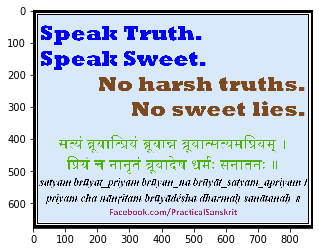

Color [255   0   0]
25
--------------
Color [ 31  73 125]
28
--------------
Color [  0 176  80]
75
--------------
Color [0 0 0]
244
--------------
Color [112  48 160]
35
--------------


In [20]:
image=cv.imread('../images/colourful_text.png')

plt.imshow(image)
plt.show()

image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
# (T,binary_image)=cv2.threshold(image,128,255,cv2.THRESH_BINARY)
# binary_image=binary_image//255

c = np.array([[255,   0,   0],[ 31,  73, 125],[  0, 176,  80],[0,0,0],[112,  48, 160]])

for i in range(5):
    img = np.zeros((image.shape[0],image.shape[1]))
    img[find_ind(image,c[i])] = 1
    [twopass_image,mapping] = TPA(img)
    print("Color",c[i])
    print(np.unique(twopass_image).size)
    print("--------------")

In [17]:
def find(image,count):
    out = np.zeros(image.shape,dtype=int)
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    img  = np.copy(image)
    neg_image=255-image
    neg_image=neg_image//255
    image=image//255
    
    [twopass_image,mapping]=TPA(image)
    im_unique,im_count=np.unique(twopass_image,return_counts=True)
    
    [neg_twopass_image,neg_mapping]=TPA(neg_image)
    negim_unique,negim_count=np.unique(neg_twopass_image,return_counts=True)
    
    indices=np.zeros(negim_unique.size)
    for i in range(2,negim_unique.size):
        if negim_unique[i]!=0:
            x=np.where(neg_twopass_image==negim_unique[i])
            up_r=x[0][0]
            up_c=x[1][0]
            if twopass_image[up_r-1,up_c]!=0:
                indices[i]=twopass_image[up_r-1,up_c]
        
    indices,cnt=np.unique(indices,return_counts=True)
    
    for i in range(indices.size):
        if cnt[i]==count and indices[i]!=0:
            out[twopass_image==indices[i]]=1
            
    f, axarr = plt.subplots(1,2,figsize=(15,10))
    axarr[0].imshow(img,cmap="gray")
    axarr[1].imshow(out,cmap="gray")
    axarr[0].set_title("Given Image")
    axarr[1].set_title("Only those letters that enclose " +str(count)+ " empty region")

<Figure size 720x720 with 0 Axes>

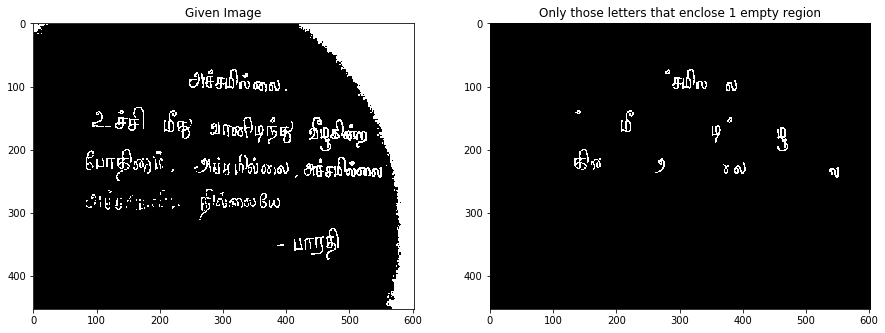

<Figure size 720x720 with 0 Axes>

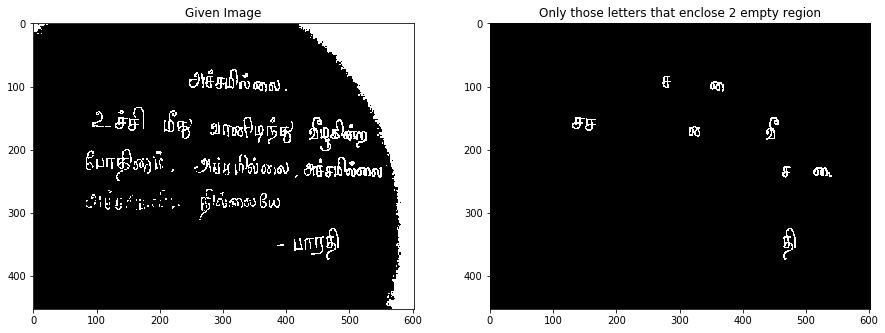

In [18]:
img = cv.cvtColor(cv.imread('../images/tamil.jpeg'),cv.COLOR_BGR2RGB)
a = img[:,:,2]
_,img = cv.threshold(a,200,255,cv.THRESH_BINARY)
img=erosion(img,2)
img = 255 - img

find(img,1)
find(img,2)

<Figure size 720x720 with 0 Axes>

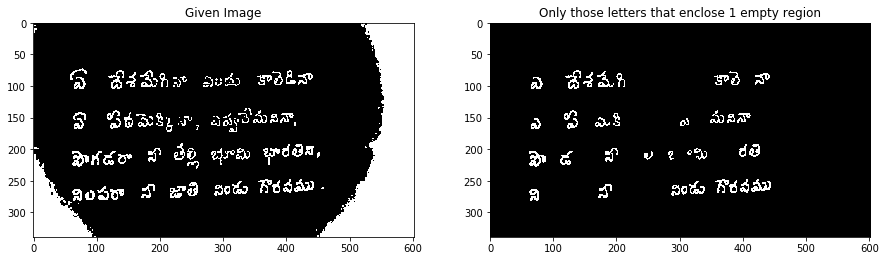

<Figure size 720x720 with 0 Axes>

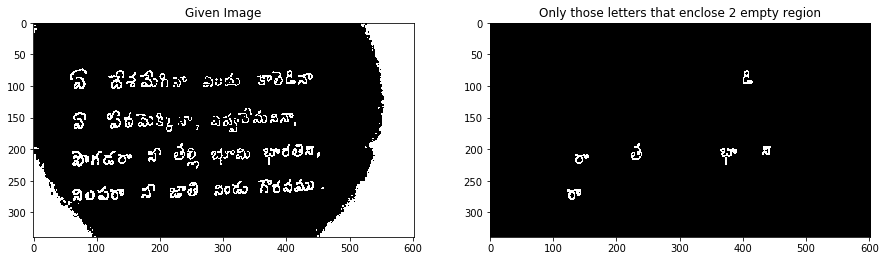

In [19]:
img = cv.cvtColor(cv.imread('../images/telugu.jpeg'),cv.COLOR_BGR2RGB)
a = img[:,:,2]
_,img = cv.threshold(a,110,255,cv.THRESH_BINARY)
img=erosion(img,2)
img = 255 - img

find(img,1)
find(img,2)